# Script to calibrate the position data of PBPS117
### Purpose:
Contact christopher.arrell@psi.ch

In [1]:
import epics as ep
from bsread import source
import numpy as np
import matplotlib.pyplot as plt
from time import sleep
from bsread import source
from IPython.display import clear_output, display
from scipy.optimize import curve_fit
%matplotlib inline

## Setup and functions setup

In [2]:
channels = ['SAROP11-CVME-PBPS2:Lnk9Ch13-DATA-SUM','SAROP11-CVME-PBPS2:Lnk9Ch11-DATA-SUM','SAROP11-CVME-PBPS2:Lnk9Ch14-DATA-SUM','SAROP11-CVME-PBPS2:Lnk9Ch15-DATA-SUM']
channel_names = ['Down','Up','Right','Left']
PBPS_x_PV_name = 'SAROP11-PBPS117:MOTOR_X1.VAL'
PBPS_y_PV_name = 'SAROP11-PBPS117:MOTOR_Y1.VAL'

PBPS_x_PV = ep.PV(PBPS_x_PV_name)
PBPS_y_PV = ep.PV(PBPS_y_PV_name)


def set_PBPS_x(pos):
    PBPS_x_PV.put(pos, wait=True)
def set_PBPS_y(pos):
    PBPS_y_PV.put(pos, wait=True)
    
def make_arrays(pvs, n_pulses):
    arrays = []
    for pv in pvs:
        val = pv.value

        dtype = get_dtype(val)
        shape = get_shape(val)
        shape = (n_pulses,) + shape

        arr = np.empty(shape, dtype)
        arrays.append(arr)

    return arrays

def PBPS_get_data(channels, n_pulses=100, wait_time=0.5):
    pvs = [ep.PV(ch) for ch in channels]

    n_channels = len(channels)
    counters = np.zeros(n_channels, dtype=int)

    arrays = make_arrays(pvs, n_pulses)


    def on_value_change(pv=None, ichannel=None, value=None, **kwargs):
        ivalue = counters[ichannel]
        arrays[ichannel][ivalue] = value

        counters[ichannel] += 1

        if counters[ichannel] == n_pulses:
            pv.clear_callbacks()


    for i, pv in enumerate(pvs):
        pv.add_callback(callback=on_value_change, pv=pv, ichannel=i)

    while not np.all(counters == n_pulses):
        sleep(wait_time)

    return(arrays)

def PBPS_get_data_bs(channels, n_pulses=100):
    Down = []
    Up = []
    Right = []
    Left = []
    pulseID = []
    horizontal = []
    vertical = []

    with source(channels=channels) as stream:
        for i in range(0,n_pulses):
            message = stream.receive()

            tmp_Down = message.data.data[channels[0]].value
            tmp_Up = message.data.data[channels[1]].value
            tmp_Right = message.data.data[channels[2]].value
            tmp_Left = message.data.data[channels[3]].value

            if None in(tmp_Down,tmp_Up,tmp_Right, tmp_Left):
                continue      
            Down.append(tmp_Down)
            Up.append(tmp_Up)
            Right.append(tmp_Right)
            Left.append(tmp_Left)
            horizontal.append((tmp_Left-tmp_Right)/(tmp_Left+tmp_Right))
            vertical.append((tmp_Up-tmp_Down)/(tmp_Up+tmp_Down))
            pulseID.append(message.data.pulse_id)
    arrays = np.zeros(shape = (1, 4, n_pulses))
    arrays[0,0,:]= np.array(Down)
    arrays[0,1,:]= np.array(Up)
    arrays[0,2,:]= np.array(Right)
    arrays[0,3,:]= np.array(Left)
    return(arrays,np.asarray(horizontal), np.asarray(vertical))

def get_dtype(v):
    if is_array(v):
        return v.dtype
    else:
        return type(v)

def get_shape(v):
    if is_array(v):
        return v.shape
    else:
        return tuple()

def is_array(v):
    return isinstance(v, np.ndarray)

def PBPS_x_scan(Scan_x_range,channels, numShots):
        
    scan_mean = []
    scan_std = []
    scan_all = []
            
    for pos in Scan_x_range:
        set_PBPS_x(pos)  
        data = PBPS_get_data(channels, numShots)
        scan_mean.append([i.mean() for i in data])
        scan_std.append([i.std() for i in data])
        scan_all.append(data)
    return(np.asarray(scan_mean), np.asarray(scan_std), np.asarray(scan_all))

def PBPS_y_scan(Scan_y_range,channels, numShots):
        
    scan_mean = []
    scan_std = []
    scan_all = []
            
    for pos in Scan_y_range:
        set_PBPS_y(pos)  
        data = PBPS_get_data(channels, numShots)
        scan_mean.append([i.mean() for i in data])
        scan_std.append([i.std() for i in data])
        scan_all.append(data)
    return(np.asarray(scan_mean), np.asarray(scan_std), np.asarray(scan_all))

def PBPS_I_calibrate(channels, numShots):
        
    scan_mean = []
    scan_std = []
    scan_all = []

    data = PBPS_get_data(channels, numShots)
    scan_mean.append([i.mean() for i in data])
    scan_std.append([i.std() for i in data])
    scan_all.append(data)
    return(np.asarray(scan_mean), np.asarray(scan_std), np.asarray(scan_all))

def lin_fit(x,m,a):
    return m*x+a
def fit(xdata,ydata):
    popt, pcov = curve_fit(lin_fit, xdata, ydata)
    return(popt)

## User inputs

In [17]:
numShots = 500
Scan_x_range = np.linspace(-0.5,0.5,10)
Scan_y_range = np.linspace(-0.5,0.5,10)

## Scan and measure

In [4]:
scan_I_mean,scan_I_std, scan_I_all = PBPS_I_calibrate(channels, numShots*5)
norm_diodes = np.asarray([1 / tm / 4 for tm in scan_I_mean])

In [14]:
scan_I_all, jitter_horz, jitter_vert = PBPS_get_data_bs(channels, numShots)
norm_diodes = np.asarray([1 / tm / 4 for tm in scan_I_mean])

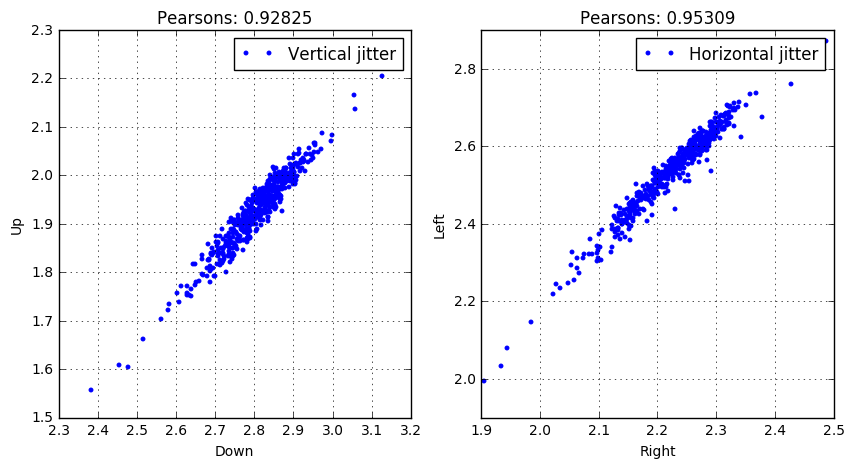

In [15]:
plt.figure(figsize=[10,5])
plt.subplot(121)
plt.title("Pearsons: %.5f"%np.corrcoef(scan_I_all[0,0,:],scan_I_all[0,1,:],)[1,0]**2)
plt.plot(scan_I_all[0,0,:],scan_I_all[0,1,:],'.', label = 'Vertical jitter')
# plt.xlim([1.7, 3.2])
plt.xlabel(channel_names[0])
plt.ylabel(channel_names[1])
plt.legend()
plt.grid(True)
plt.subplot(122)
plt.title("Pearsons: %.5f"%np.corrcoef(scan_I_all[0,2,:],scan_I_all[0,3,:],)[1,0]**2)
plt.plot(scan_I_all[0,2,:],scan_I_all[0,3,:],'.', label = 'Horizontal jitter')
plt.xlabel(channel_names[2])
plt.ylabel(channel_names[3])
plt.grid(True)
plt.legend()

In [31]:
scan_x_mean,scan_x_std, scan_x_data = PBPS_x_scan(Scan_x_range, channels, numShots)
#scan_x_mean,scan_x_std, scan_x_data = PBPS_x_scan(Scan_x_range, channels, numShots)

set_PBPS_x(0)

In [19]:
scan_y_mean,scan_y_std, _ = PBPS_y_scan(Scan_y_range, channels, numShots)
set_PBPS_y(0)

In [20]:
popt_x = []
for i in range(0,scan_x_mean.shape[1]):
    popt_x.append(fit(Scan_x_range,scan_x_mean[:,i]))
popt_x =np.asarray(popt_x)

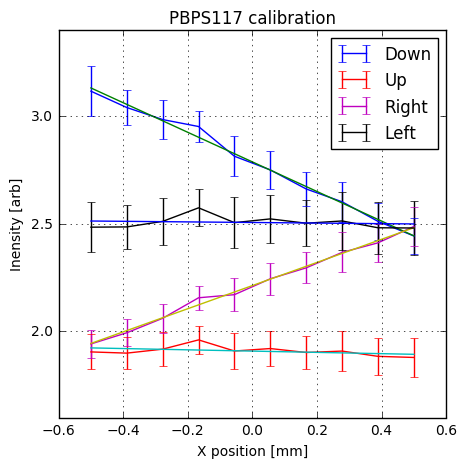

In [23]:
plt.figure(figsize=[5,5])
for i in range(0,scan_x_mean.shape[1]):
    plt.errorbar(Scan_x_range, scan_x_mean[:,i], yerr=scan_x_std[:,i],label = channel_names[i])
    plt.plot(Scan_x_range,lin_fit(Scan_x_range,*popt_x[i,:]))
plt.legend()
plt.grid(True)
plt.title('PBPS117 calibration')
plt.xlabel('X position [mm]')
plt.ylabel('Inensity [arb]')

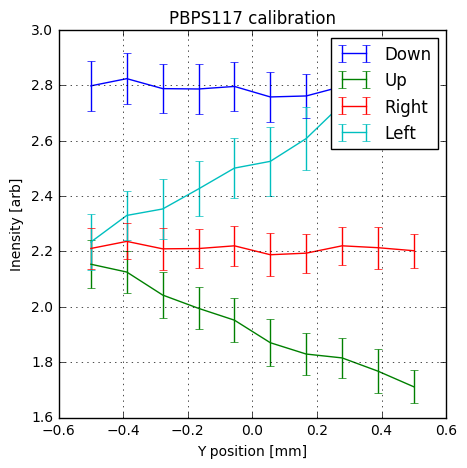

In [24]:
plt.figure(figsize=[5,5])
for i in range(0,scan_y_mean.shape[1]):
    plt.errorbar(Scan_y_range, scan_y_mean[:,i], yerr=scan_y_std[:,i],label = channel_names[i])
plt.legend()
plt.grid(True)
plt.title('PBPS117 calibration')
plt.xlabel('Y position [mm]')
plt.ylabel('Inensity [arb]')

## Calibrate

In [49]:
#norm_diodes = np.asarray([1 / tm / 4 for tm in scan_I_mean])
scan_x_norm = (scan_x_mean[:,3]*norm_diodes[0,3]-scan_x_mean[:,2]*norm_diodes[0,2])/(scan_x_mean[:,3]*norm_diodes[0,3]+scan_x_mean[:,2]*norm_diodes[0,2])
scan_y_norm = (scan_y_mean[:,1]*norm_diodes[0,1]-scan_y_mean[:,0]*norm_diodes[0,0])/(scan_y_mean[:,1]*norm_diodes[0,1]+scan_y_mean[:,0]*norm_diodes[0,0])


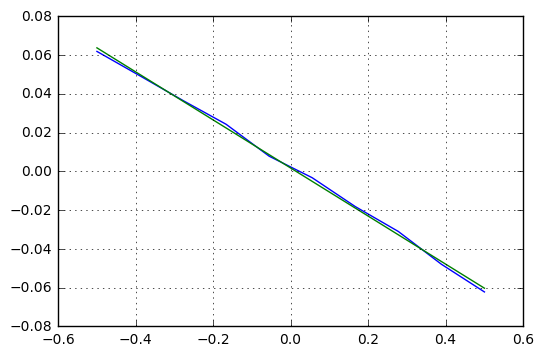

In [48]:
popt_norm_x = fit(Scan_x_range,scan_x_norm)
plt.figure()
plt.plot(Scan_x_range, scan_x_norm)
plt.plot(Scan_x_range,lin_fit(Scan_x_range,*popt_norm_x))
plt.grid(True)

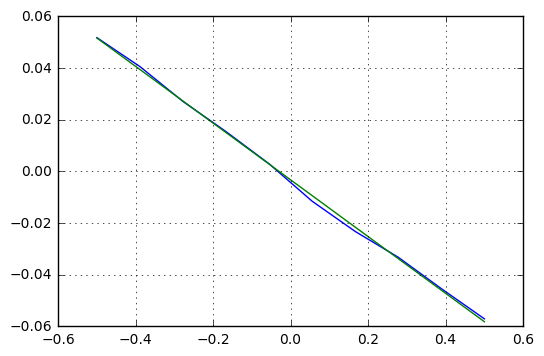

In [50]:
popt_norm_y = fit(Scan_y_range,scan_y_norm)
plt.figure()
plt.plot(Scan_y_range, scan_y_norm)
plt.plot(Scan_y_range,lin_fit(Scan_y_range,*popt_norm_y))
plt.grid(True)

In [28]:
# set intensities
ep.PV('SARES12-CVME-EVR0:CALCI.INPE').put(bytes(str(norm_diodes[0,0]), "utf8"))
ep.PV('SARES12-CVME-EVR0:CALCI.INPF').put(bytes(str(norm_diodes[0,1]), "utf8"))
ep.PV('SARES12-CVME-EVR0:CALCI.INPG').put(bytes(str(norm_diodes[0,2]), "utf8"))
ep.PV('SARES12-CVME-EVR0:CALCI.INPH').put(bytes(str(norm_diodes[0,3]), "utf8"))

1

In [41]:
# set x position
ep.PV('SARES12-CVME-EVR0:CALCX.INPE').put(bytes(str(norm_diodes[0,2]), "utf8"))
ep.PV('SARES12-CVME-EVR0:CALCX.INPF').put(bytes(str(norm_diodes[0,3]), "utf8"))
ep.PV('SARES12-CVME-EVR0:CALCX.INPI').put(bytes(str(-1*(Scan_x_range[1]-Scan_x_range[0])/ np.diff(scan_x_norm).mean()), "utf8"))

1

In [51]:
# set y position
ep.PV('SARES12-CVME-EVR0:CALCY.INPE').put(bytes(str(norm_diodes[0,0]), "utf8"))
ep.PV('SARES12-CVME-EVR0:CALCY.INPF').put(bytes(str(norm_diodes[0,1]), "utf8"))
ep.PV('SARES12-CVME-EVR0:CALCY.INPI').put(bytes(str(-1*(Scan_y_range[1]-Scan_y_range[0])/ np.diff(scan_y_norm).mean()), "utf8"))

1

## Test scans
### The purpose of the cells bellow is to scan the PBPS with the calibrated values.  The results can be seen in the data buffer ui here:
[Vertical](https://ui-data-api.psi.ch/loadhash/2021-02-24/ea0acc9f682ba57f5e2aadf0bcfa049948adbebba41ef9b658cff23e97fe1078)  
[Horizontal](https://ui-data-api.psi.ch/loadhash/2021-02-24/2b4716b7de3d05b1a47f3f481a8df61fc18cc6782c338b1762be4d7eeb417d33)

In [52]:
for pos in Scan_y_range:
    set_PBPS_y(pos)
    sleep(10)
set_PBPS_y(0)

In [42]:
for pos in Scan_x_range:
    set_PBPS_x(pos)
    sleep(10)
set_PBPS_x(0)